# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
# =========================================================================== #
# STANDARD IMPORTS
# =========================================================================== #
print(__doc__)

# Critical Imports
# --------------------------------------------------------------------------- #
import warnings; warnings.filterwarnings("ignore")

# Imports through 'from' syntax
# --------------------------------------------------------------------------- #
from pprint import pprint
from itertools import islice
from os import listdir; from os.path import isfile, join
# Standard Imports
# --------------------------------------------------------------------------- #
import copy; import os
import sys; import time
import itertools
import sklearn

# Imports through 'as' syntax
# --------------------------------------------------------------------------- #
import numpy as np; import pandas as pd

# Imports for handling graphics
# --------------------------------------------------------------------------- #
%matplotlib inline
# Matplotlib pyplot provides plotting API
import matplotlib as mpl
from matplotlib import pyplot as plt
import chart_studio.plotly.plotly as py
import seaborn as sns;  sns.set(style="ticks", color_codes=True) # sns.set()

Automatically created module for IPython interactive environment


In [2]:
# =========================================================================== #
# UTILS IMPORTS (Done by myself)
# =========================================================================== #
from utils.load_dataset_pittsburg_utils import load_brdiges_dataset
from utils.display_utils import *
from utils.preprocessing_utils import *
from utils.training_utils import *
from utils.sklearn_functions_custom import *
from utils.learning_curves_custom import *
from utils.training_utils_v2 import fit_by_n_components, fit_all_by_n_components, grid_search_all_by_n_components

In [3]:
# =========================================================================== #
# sklearn IMPORT
# =========================================================================== #
from sklearn.decomposition import PCA, KernelPCA

# Import scikit-learn classes: models (Estimators).
from sklearn.naive_bayes import GaussianNB           # Non-parametric Generative Model
from sklearn.naive_bayes import MultinomialNB        # Non-parametric Generative Model
from sklearn.linear_model import LinearRegression    # Parametric Linear Discriminative Model
from sklearn.linear_model import LogisticRegression  # Parametric Linear Discriminative Model
from sklearn.linear_model import Ridge, Lasso, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC                          # Parametric Linear Discriminative "Support Vector Classifier"
from sklearn.tree import DecisionTreeClassifier      # Non-parametric Model
from sklearn.ensemble import BaggingClassifier       # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)
from sklearn.ensemble import RandomForestClassifier  # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)

In [4]:
# =========================================================================== #
# READ INPUT DATASET
# =========================================================================== #

dataset_path = 'C:\\Users\\Francesco\Documents\\datasets\\pittsburgh_dataset'
dataset_name = 'bridges.data.csv'

TARGET_COL = 'T-OR-D'  # Target variable name
dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

In [5]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [6]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #

columns = dataset.columns  # List of all attribute names

# Get Target values and map to 0s and 1s
y = np.array(list(map(lambda x: 0 if x == 1 else 1, dataset[TARGET_COL].values)))
print('Summary about Target Variable {target_col}')
print('-' * 50)
print(dataset[TARGET_COL].value_counts())

# Get Predictors
X = dataset.loc[:, dataset.columns != TARGET_COL].values

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64


In [7]:
# Standardizing the features
# --------------------------------------------------------------------------- #
scaler_methods = ['minmax', 'standard', 'norm']
scaler_method = 'standard'
rescaledX = preprocessing_data_rescaling(scaler_method, X)

shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [8]:
n_components = rescaledX.shape[1]
pca = PCA(n_components=n_components)
# pca = PCA(n_components=2)

# X_pca = pca.fit_transform(X)
pca = pca.fit(rescaledX)
X_pca = pca.transform(rescaledX)

In [9]:
print(f"Cumulative varation explained(percentage) up to given number of pcs:")

tmp_data = []
principal_components = [pc for pc in '2,5,6,7,8,9,10'.split(',')]
for _, pc in enumerate(principal_components):
    n_components = int(pc)
    
    cum_var_exp_up_to_n_pcs = np.cumsum(pca.explained_variance_ratio_)[n_components-1]
    # print(f"Cumulative varation explained up to {n_components} pcs = {cum_var_exp_up_to_n_pcs}")
    # print(f"# pcs {n_components}: {cum_var_exp_up_to_n_pcs*100:.2f}%")
    tmp_data.append([n_components, cum_var_exp_up_to_n_pcs * 100])

tmp_df = pd.DataFrame(data=tmp_data, columns=['# PCS', 'Cumulative Varation Explained (percentage)'])
tmp_df.head(len(tmp_data))

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA



## Learning Models <a class="anchor" id="learning-models"></a>

In [10]:
# Parameters to be tested for Cross-Validation Approach

estimators_list = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
estimators_names = ['GaussianNB', 'LogisticRegression', 'KNeighborsClassifier', 'SGDClassifier', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier']
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))

pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = [10, 9, 8, 7, 6, 5, 4, 3, 2]

parmas_logistic_regression = {
    'penalty': ('l1', 'l2', 'elastic'),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'C': (1.0, .1, .01, .001),
}

parmas_knn_forest = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
}

parameters_sgd_classifier = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6)
}

kernel_type = 'svm-rbf-kernel'
parameters_svm = {
    'gamma': (0.003, 0.03, 0.05, 0.5, 0.7, 1.0, 1.5),
    'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    # 'penalty': ('l2','l1'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'C': (1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3),
    'probability': (True,), 
}

parmas_decision_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'auto', 'sqrt', 'log2')
}

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False)
}

param_grids = [parmas_logistic_regression, parmas_knn_forest, parameters_sgd_classifier, parameters_svm, parmas_decision_tree, parmas_random_forest]

N_CV, N_KERNEL, N_GS = 9, 4, 6

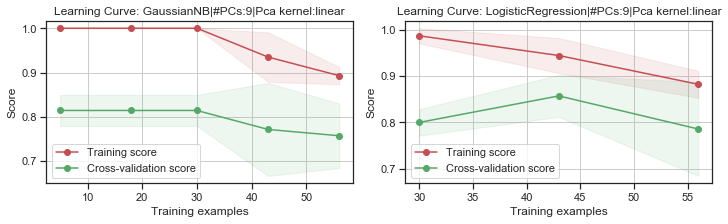

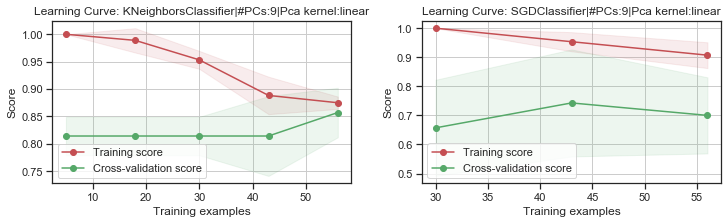

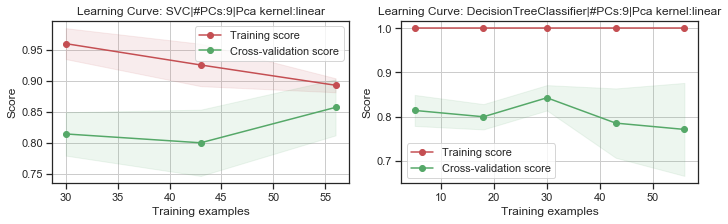

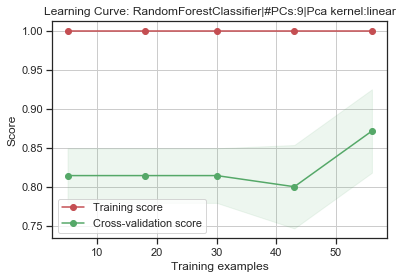

In [11]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=list(range(5, 50)),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='neg_brier_score',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}")
    # figsize=(20,5)
)

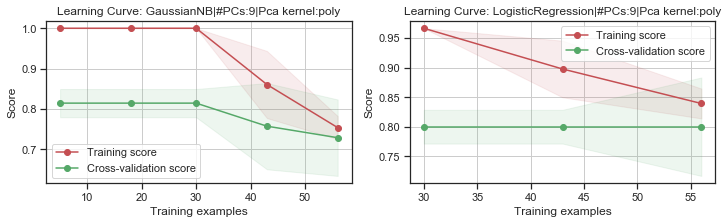

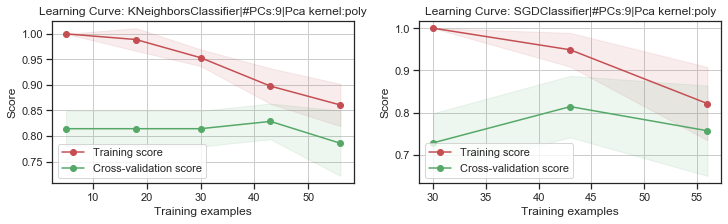

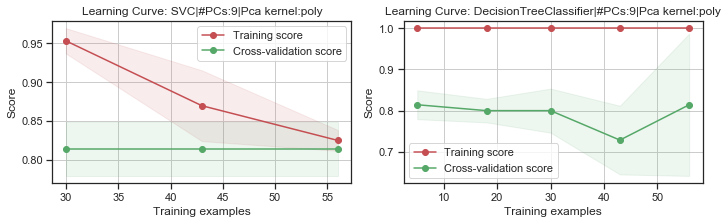

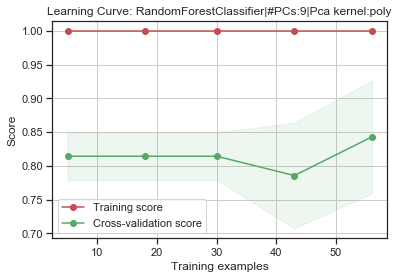

In [12]:
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=list(range(5, 50)),
    n_components=9,
    pca_kernels_list=pca_kernels_list[1],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='neg_log_loss',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}")
    # figsize=(20,5)
)

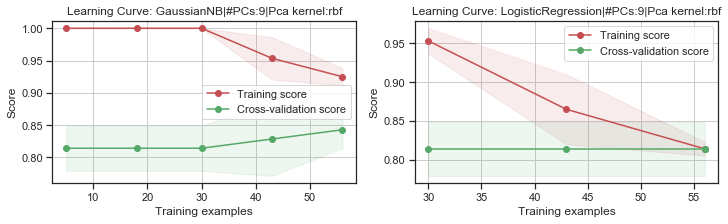

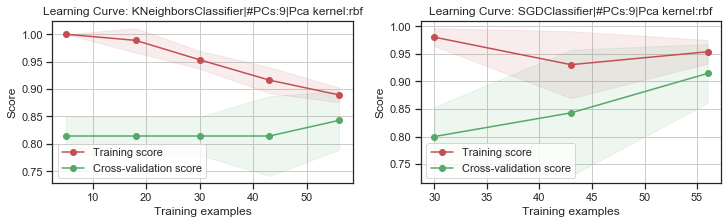

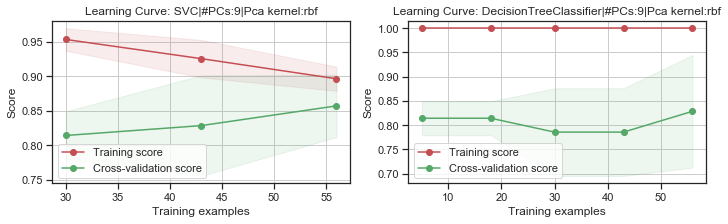

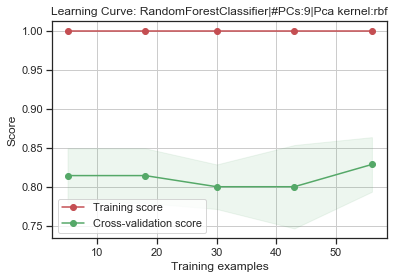

In [13]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=list(range(5, 50)),
    n_components=n_components,
    pca_kernels_list=pca_kernels_list[2],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='neg_log_loss',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}")
    # figsize=(20,5)
)

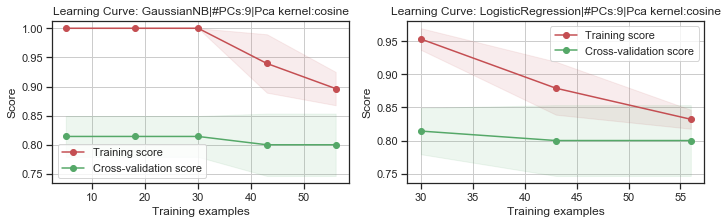

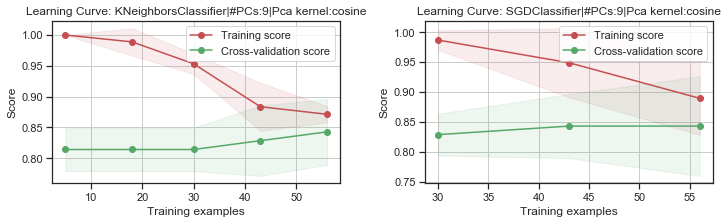

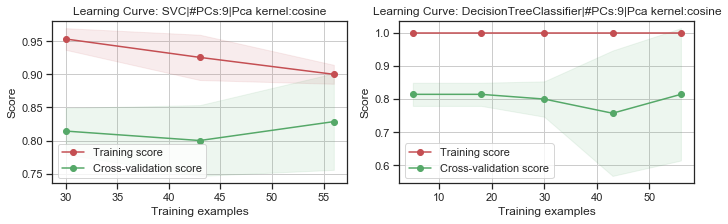

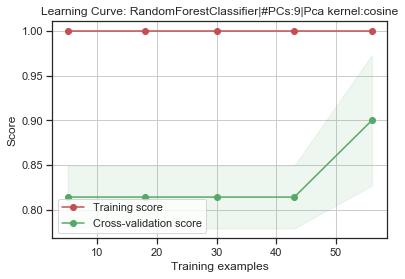

In [14]:
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=list(range(5, 50)),
    n_components=9,
    pca_kernels_list=pca_kernels_list[3],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='neg_log_loss',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}")
    # figsize=(20,5)
)

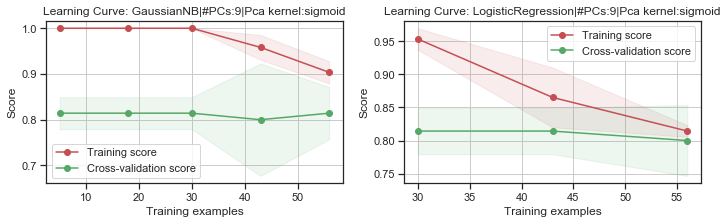

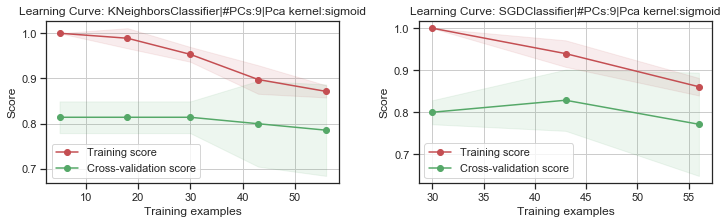

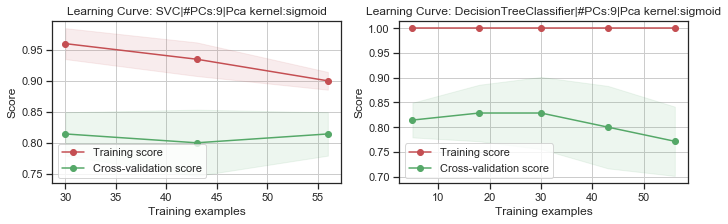

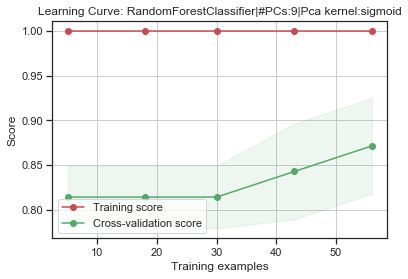

In [15]:
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=list(range(5, 50)),
    n_components=9,
    pca_kernels_list=pca_kernels_list[4],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='neg_log_loss',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}")
    # figsize=(20,5)
)

In [17]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [16]:
n_components=9
scoring='accuracy'
figs_dest =os.path.join('figures', 'learning_curve', f"Pcs_{n_components}", scoring)

def merge_images_within_dir(pca_kernels_list, figs_dest):
    for i, kernel in enumerate(pca_kernels_list):
        dir_target = os.path.join(figs_dest, kernel)
        images = [f for f in listdir(dir_target) if isfile(join(dir_target, f))]
    
        def starts_with_merged(a_file):
            return os.path.basename(a_file).startswith("merged") is False
    
        images = list(filter(lambda xi: starts_with_merged(xi), images))
        fig = plt.figure(figsize=(20, 20))
        for j, image in enumerate(images):
            ax = fig.add_subplot(4, 1, j+1)
            full_path_img = os.path.join(dir_target, image)
            img = mpimg.imread(full_path_img)
            plt.imshow(img)
        full_path_img = os.path.join(dir_target, "merged_learning_curves.png")
        plt.savefig(full_path_img)
        pass
    pass
merge_images_within_dir(pca_kernels_list, figs_dest)

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: 'figures\\learning_curve\\Pcs_9\\accuracy\\linear'

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    
    return

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, rescaledX, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

plt.show()

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

### References  <a class="anchor" id="references"></a>
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (SVM) https://scikit-learn.org/stable/modules/svm.html
    - (PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Markdown Math part:
    - https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html
    
#### others
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Third Party Library:
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
- KDE:
    - (TUTORIAL) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c